In [3]:
# ==============================
# 📦 Core Python Libraries
# ==============================
import json
from datetime import datetime

# ==============================
# 🧮 Scientific & Data Libraries
# ==============================
import numpy as np
import pandas as pd

# ==============================
# 🫀 Signal Processing & EDF I/O
# ==============================
from util.read_edf import read_edf_metadata, read_edf_to_dataframes, get_sampling_rate

# ==============================
# 🧠 Quality Control Modules
# ==============================
from quality.ecg_quality import run_ecg_qc
from quality.flow_quality import run_flow_qc
from quality.eeg_quality import calculate_quality

# ==============================
# 📊 Visualization
# ==============================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### READ THE METADATA

In [4]:
edf_metadata_df = read_edf_metadata("ABC100110013333PSG06.edf")
edf_metadata_df.head(50)

Channel #         Label  Sample Frequency (Hz) Physical Unit  \
0           1    EOG LOC-A2                  500.0            uV   
1           2    EOG ROC-A2                  500.0            uV   
2           3      EMG Chin                  500.0            uV   
3           4      EMG Aux2                  500.0            uV   
4           5     EEG F3-A2                  500.0            uV   
5           6     EEG F4-A1                  500.0            uV   
6           7     EEG C3-A2                  500.0            uV   
7           8     EEG C4-A1                  500.0            uV   
8           9     EEG O1-A2                  500.0            uV   
9          10     EEG O2-A1                  500.0            uV   
10         11        ECG II                  200.0            uV   
11         12            RR                   10.0                 
12         13         Leg 2                  500.0            uV   
13         14         Leg 1                  500.0            uV   
14         15  Flow Patient                  100.0                 
15         16  Flow Patient                  100.0                 
16         17    Effort THO                  100.0                 
17         18    Effort ABD                  100.0                 
18         19          SpO2                    1.0             %   
19         20     EEG A1-A2                  500.0            uV   
20         21    PressCheck                    1.0                 
21         22      ECG IIHF                 1000.0            uV   
22         23     Technical                  200.0                 

    Physical Min  Physical Max  Digital Min  Digital Max  \
0         -313.0         313.0       -32768        32767   
1         -313.0         313.0       -32768        32767   
2          -78.0          78.0       -32768        32767   
3          -78.0          78.0       -32768        32767   
4         -313.0         313.0       -32768        32767   
5         -313.0         313.0       -32768        32767   
6         -313.0         313.0       -32768        32767   
7         -313.0         313.0       -32768        32767   
8         -313.0         313.0       -32768        32767   
9         -313.0         313.0       -32768        32767   
10       -8333.0        8333.0       -32768        32767   
11           0.0         200.0            0          200   
12         -78.0          78.0       -32768        32767   
13         -78.0          78.0       -32768        32767   
14        -100.0         100.0       -32768        32767   
15        -100.0         100.0       -32768        32767   
16        -100.0         100.0       -32768        32767   
17        -100.0         100.0       -32768        32767   
18           0.0         102.3            0         1023   
19        -313.0         313.0       -32768        32767   
20           0.0       65535.0       -32768        32767   
21       -8333.0        8333.0       -32768        32767   
22           0.0       65535.0       -32768        32767   

                        Prefilter              Transducer  Num Samples  \
0     HP:0.3Hz LP:180Hz N:50/60Hz                             16235000   
1     HP:0.3Hz LP:180Hz N:50/60Hz                             16235000   
2      HP:10Hz LP:180Hz N:50/60Hz                             16235000   
3      HP:10Hz LP:180Hz N:50/60Hz                             16235000   
4     HP:0.3Hz LP:180Hz N:50/60Hz                             16235000   
5     HP:0.3Hz LP:180Hz N:50/60Hz                             16235000   
6     HP:0.3Hz LP:180Hz N:50/60Hz                             16235000   
7     HP:0.3Hz LP:180Hz N:50/60Hz                             16235000   
8     HP:0.3Hz LP:180Hz N:50/60Hz                             16235000   
9     HP:0.3Hz LP:180Hz N:50/60Hz                             16235000   
10  HP:0.04Hz LP:93.6Hz N:50/60Hz                              6494000   
11                                        

In [5]:
# --- Automatically detect sampling frequency for key channels ---

fs_ecg = int(get_sampling_rate("ECG II", edf_metadata_df))
fs_flow_therm = int(get_sampling_rate("Flow Patient (Thermistor)", edf_metadata_df))
fs_flow_press = int(get_sampling_rate("Flow Patient (Pressure)", edf_metadata_df))

# EEG channels
eeg_channels = ['EEG F3-A2', 'EEG F4-A1', 'EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1']
fs_eeg_dict = {ch: int(get_sampling_rate(ch, edf_metadata_df)) for ch in eeg_channels}

print("Detected Sampling Frequencies:")
print(f"  ECG II → {fs_ecg} Hz")
print(f"  Flow Patient (Thermistor) → {fs_flow_therm} Hz")
print(f"  Flow Patient (Pressure) → {fs_flow_press} Hz")
for ch, rate in fs_eeg_dict.items():
    print(f"  {ch:<10} → {rate} Hz")

Detected Sampling Frequencies:
  ECG II → 200 Hz
  Flow Patient (Thermistor) → 100 Hz
  Flow Patient (Pressure) → 100 Hz
  EEG F3-A2  → 500 Hz
  EEG F4-A1  → 500 Hz
  EEG C3-A2  → 500 Hz
  EEG C4-A1  → 500 Hz
  EEG O1-A2  → 500 Hz
  EEG O2-A1  → 500 Hz


### READ THE CHANNEL INTO DATAFRAMES

In [6]:
channel_dataframes = read_edf_to_dataframes("ABC100110013333PSG06.edf")
print(channel_dataframes.keys())
# The EDF file contains 23 signals (EOG, EEG, EMG, ECG, etc.).

dict_keys(['EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'EMG Aux2', 'EEG F3-A2', 'EEG F4-A1', 'EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1', 'ECG II', 'RR', 'Leg 2', 'Leg 1', 'Flow Patient (Thermistor)', 'Flow Patient (Pressure)', 'Effort THO', 'Effort ABD', 'SpO2', 'EEG A1-A2', 'PressCheck', 'ECG IIHF', 'Technical (RI_Diag_Device Alice_5)'])


# EEG Processing and Plots

In [7]:
# --- Define EEG channels of interest ---
channels = ['EEG F3-A2', 'EEG F4-A1', 'EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1']

# --- Automatically detect sampling frequency for EEG channels ---
fs_eeg_dict = {ch: int(get_sampling_rate(ch, edf_metadata_df)) for ch in channels}

# Verify all EEG channels share the same rate
fs_unique = set(fs_eeg_dict.values())
if len(fs_unique) != 1:
    raise ValueError(f"EEG channels have inconsistent sampling rates: {fs_unique}")
else:
    fs = fs_unique.pop()
    print(f"\n✅ All EEG channels share the same sampling rate: {fs} Hz")

epoch_len = 30  # seconds

print("=" * 60)
print("🧠 EEG Artifact Quality Control (QC) — Channel-wise Subplots")
print("=" * 60)
print(f"Channels: {', '.join(channels)}")
print(f"Sampling rate: {fs} Hz | Epoch length: {epoch_len} s\n")

# --- Load EEG signals ---
signals = []
for i, ch in enumerate(channels):
    print(f"[{i+1}/{len(channels)}] Loading {ch} ...", end="")
    df = channel_dataframes[ch]
    sig = df[ch].values.astype(float)
    signals.append(sig)
    duration_hr = len(sig) / fs / 3600
    print(f" done. ({len(sig):,} samples, {duration_hr:.2f} hours @ {fs} Hz)")
signals = np.vstack(signals)


✅ All EEG channels share the same sampling rate: 500 Hz
🧠 EEG Artifact Quality Control (QC) — Channel-wise Subplots
Channels: EEG F3-A2, EEG F4-A1, EEG C3-A2, EEG C4-A1, EEG O1-A2, EEG O2-A1
Sampling rate: 500 Hz | Epoch length: 30 s

[1/6] Loading EEG F3-A2 ... done. (16,235,000 samples, 9.02 hours @ 500 Hz)
[2/6] Loading EEG F4-A1 ... done. (16,235,000 samples, 9.02 hours @ 500 Hz)
[3/6] Loading EEG C3-A2 ... done. (16,235,000 samples, 9.02 hours @ 500 Hz)
[4/6] Loading EEG C4-A1 ... done. (16,235,000 samples, 9.02 hours @ 500 Hz)
[5/6] Loading EEG O1-A2 ... done. (16,235,000 samples, 9.02 hours @ 500 Hz)
[6/6] Loading EEG O2-A1 ... done. (16,235,000 samples, 9.02 hours @ 500 Hz)


In [8]:
signals = []
for i, ch in enumerate(eeg_channels):
    df = channel_dataframes[ch]
    sig = df[ch].values.astype(float)
    signals.append(sig)
signals = np.vstack(signals)
eeg_data = signals  # (n_channels x n_samples)

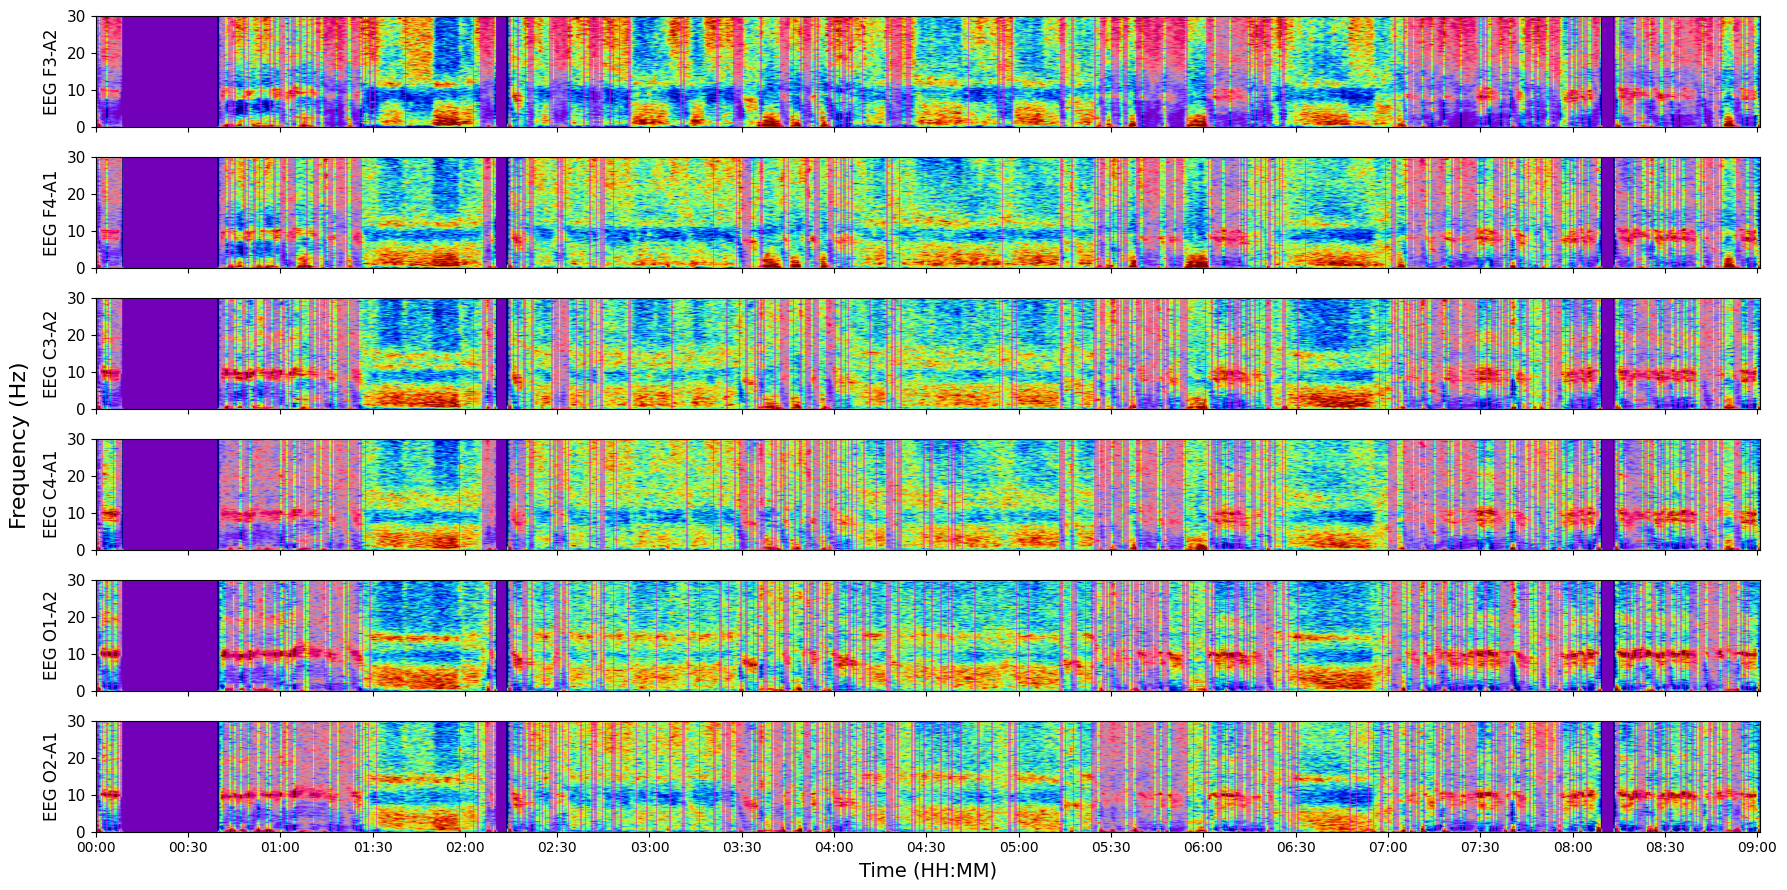

In [9]:
qc_results = calculate_quality(
    signal=eeg_data,
    sampling_rate=fs,
    channel_names=['EEG F3-A2', 'EEG F4-A1', 'EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1'],
    epoch_len=30,
    ar_thresh=6,
    plot=True
)

In [10]:
# --- Extract from qc_results ---
flags_all   = qc_results["combined_flags"]
flat_mask   = qc_results["flatline_mask"]
noise_mask  = qc_results["noise_mask"]
channels    = qc_results["metadata"]["channels"]

# --- Print formatted QC summary ---
print("📊 QC Summary (Percentage of Bad Epochs per Channel)")
for i, ch in enumerate(channels):
    bad_ratio   = np.mean(flags_all[i]) * 100
    flat_ratio  = np.mean(flat_mask[i]) * 100
    noise_ratio = np.mean(noise_mask[i]) * 100
    print(f"   {ch:<10} → {bad_ratio:6.2f}% bad (Flat: {flat_ratio:5.2f}%, Noise: {noise_ratio:5.2f}%)")


📊 QC Summary (Percentage of Bad Epochs per Channel)
   EEG F3-A2  →  45.56% bad (Flat:  6.84%, Noise: 38.72%)
   EEG F4-A1  →  37.62% bad (Flat:  6.84%, Noise: 30.78%)
   EEG C3-A2  →  40.02% bad (Flat:  6.84%, Noise: 33.18%)
   EEG C4-A1  →  45.29% bad (Flat:  6.84%, Noise: 38.45%)
   EEG O1-A2  →  40.94% bad (Flat:  6.84%, Noise: 34.10%)
   EEG O2-A1  →  48.34% bad (Flat:  6.84%, Noise: 41.50%)


# ECG Processing and Plots

In [11]:
ecg_ii_df = channel_dataframes['ECG II']
ecg_ii_df = ecg_ii_df.rename(columns={'Relative Time (s)': 'Time (s)', 'ECG II_Data': 'ECG II'})
ecg_ii_df["Absolute Time"] = pd.to_datetime(ecg_ii_df["Absolute Time"])

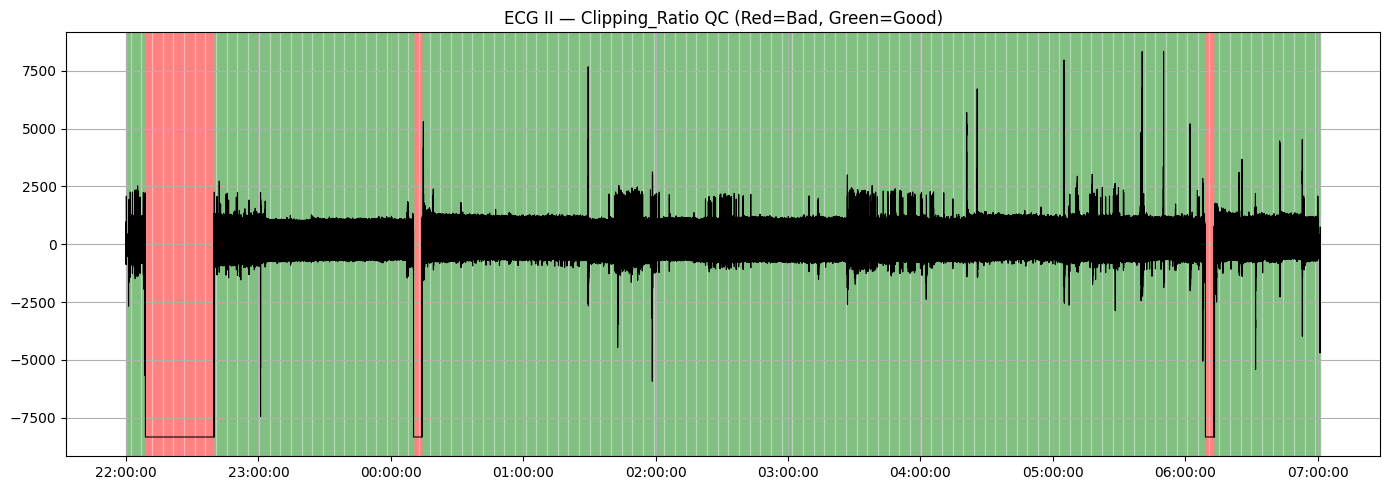

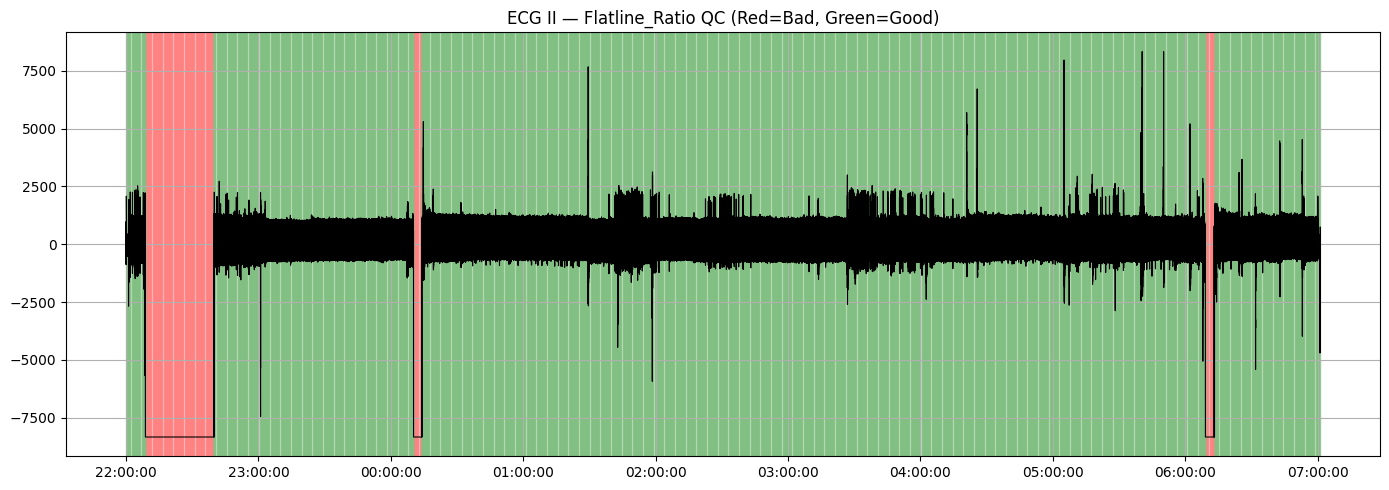

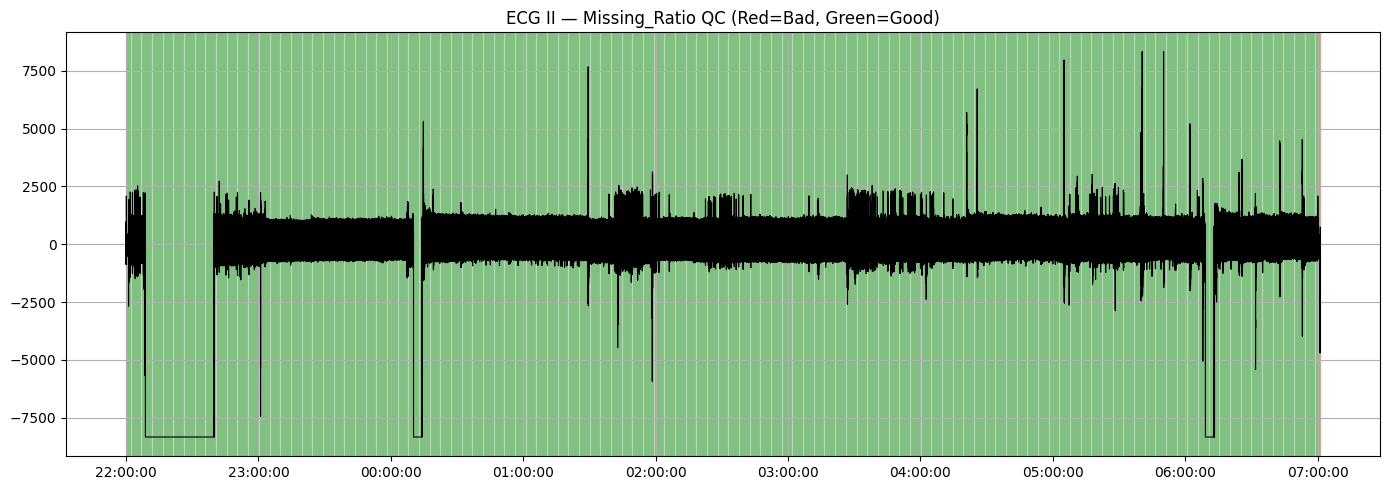

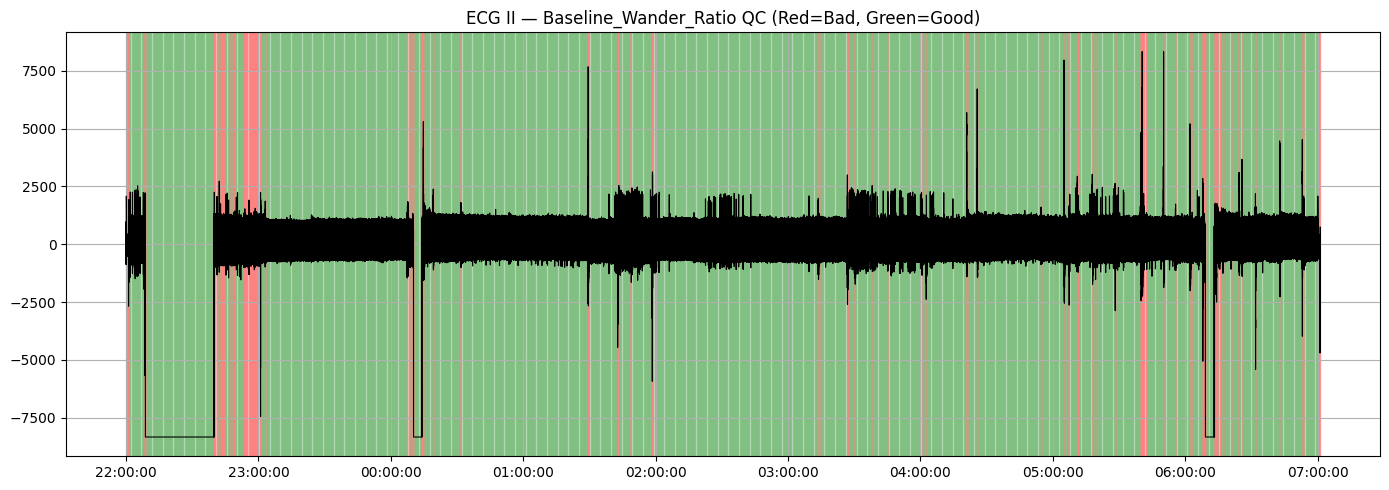

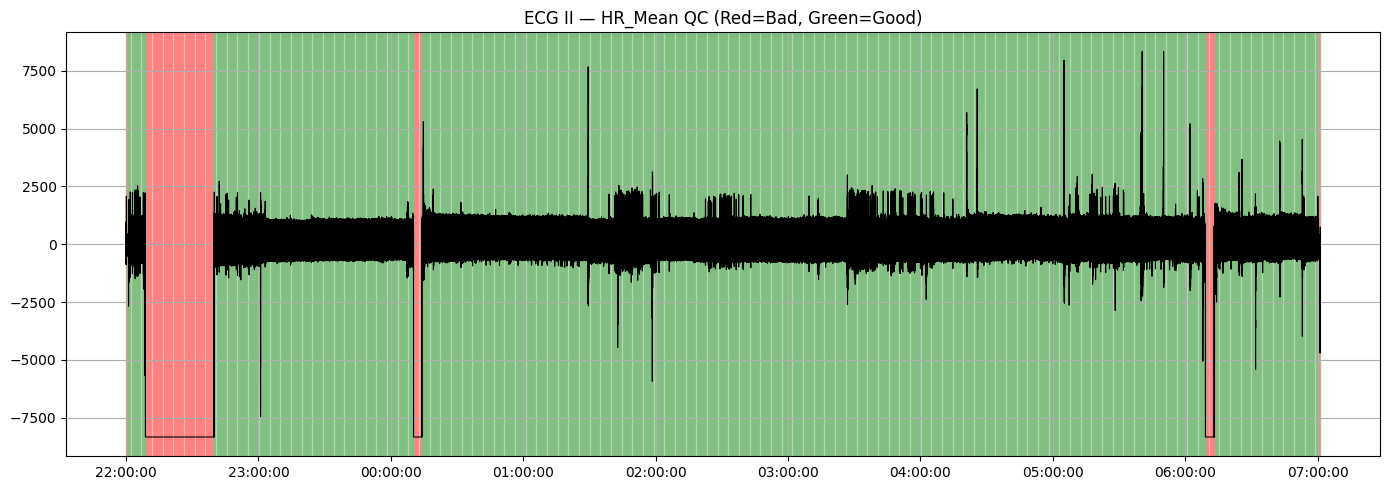

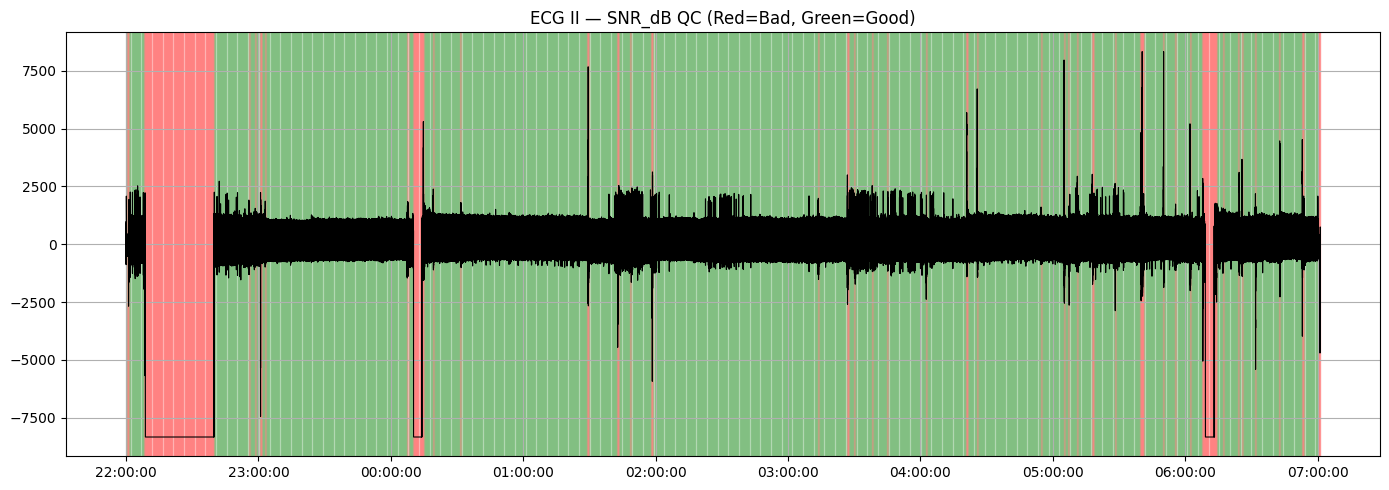

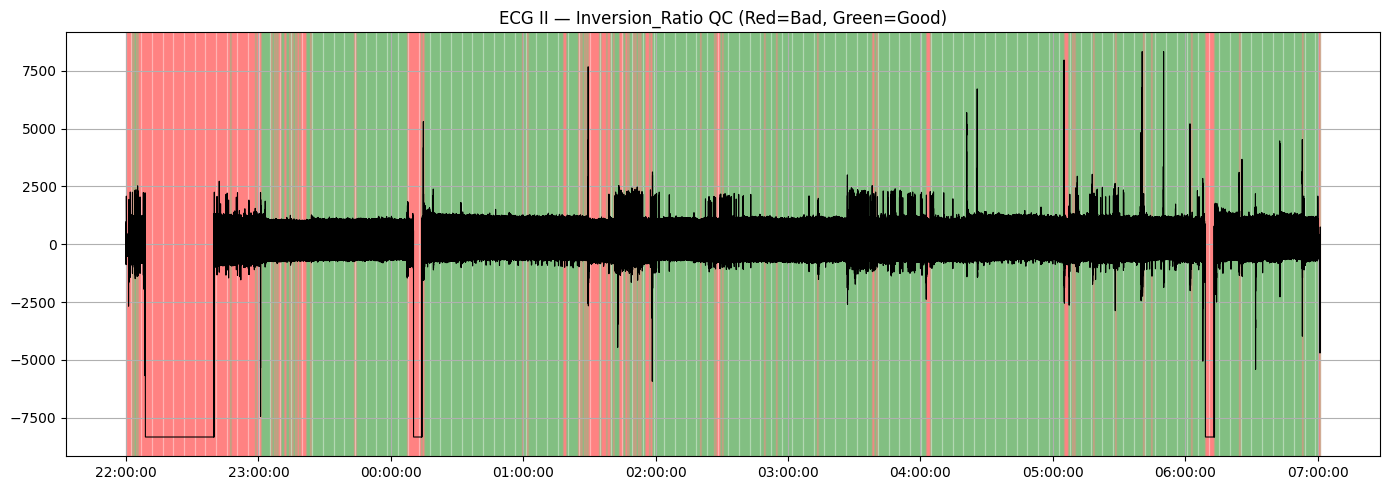

{'total_epochs': 1083, 'good_epochs': 799, 'bad_epochs': 284, 'good_ratio': 0.738, 'bad_ratio': 0.262}


In [27]:
per_epoch, per_metric_json, overall_json = run_ecg_qc(
    "ECG II",
    channel_dataframes=channel_dataframes,
    fs=fs_ecg,
    epoch_len=30,
    thresholds={
        "clipping_max": 0.50,
        "flatline_max": 0.50,
        "missing_max": 0.50,
        "baseline_max": 0.15,
        "hr_min": 25.0,
        "hr_max": 220.0,
        "snr_min": 5.0,
        "inv_ratio_max": 0.5, 
    },
    json_path="qc_summary.json",
    plot="per-metric"  # "overall" or "both" are also valid
)

print(overall_json)

In [26]:
overall_json

{'total_epochs': 1083,
 'good_epochs': 374,
 'bad_epochs': 709,
 'good_ratio': 0.345,
 'bad_ratio': 0.655}

In [13]:

# --- Save per_epoch to a separate JSON file ---
with open("per_epoch_ecg.json", "w") as f:
    json.dump(per_epoch, f, indent=2)

print("✅ Saved per-epoch QC details to per_epoch.json")

✅ Saved per-epoch QC details to per_epoch.json


✅ Loaded 1083 epochs from per_epoch_ecg.json
📊 Available metrics for plotting: ['Clipping_Ratio', 'Flatline_Ratio', 'Missing_Ratio', 'Baseline_Wander_Ratio', 'HR_Mean', 'SNR_dB']


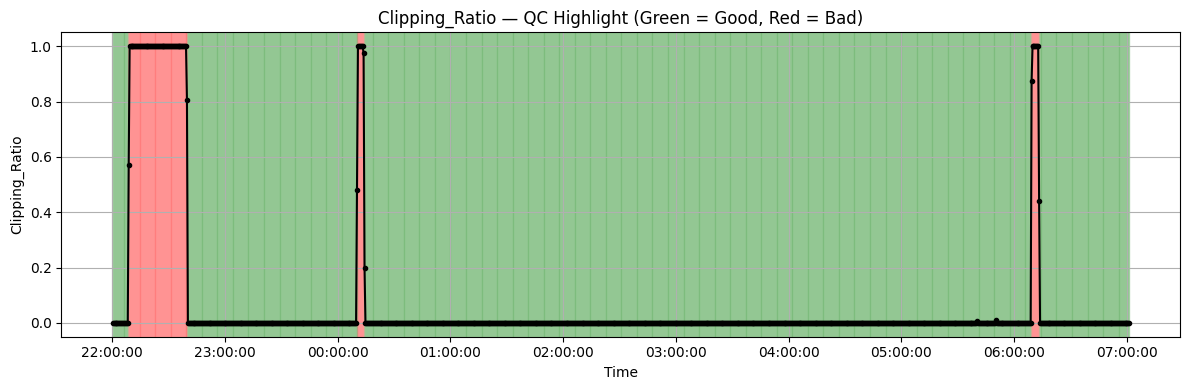

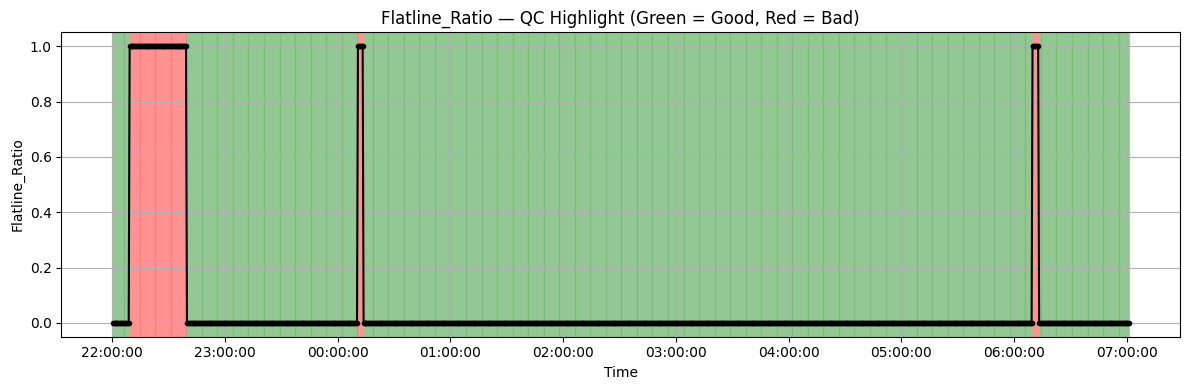

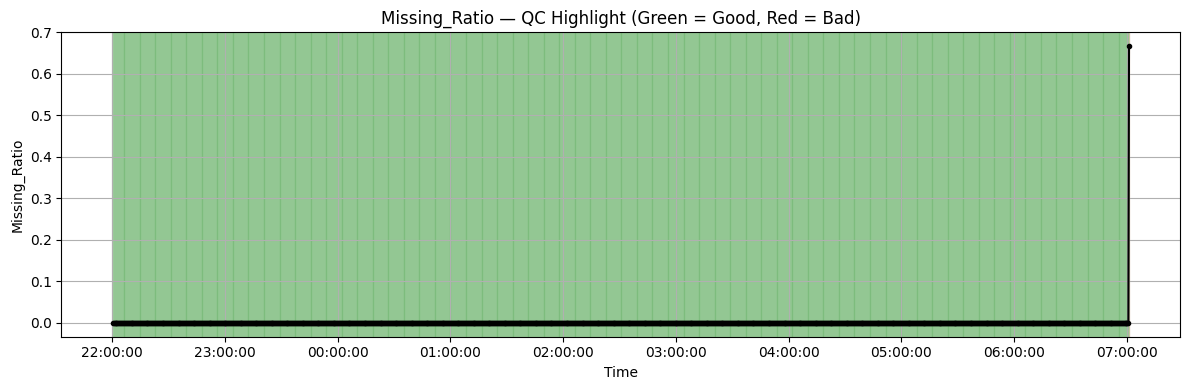

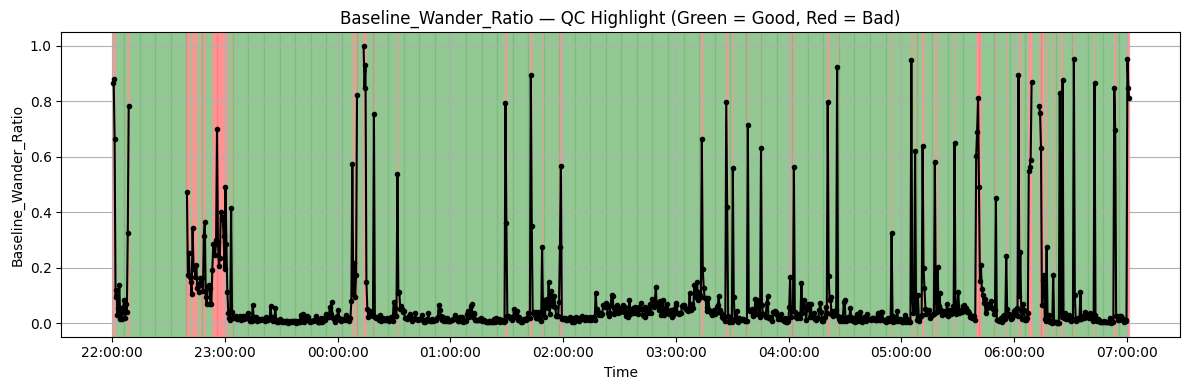

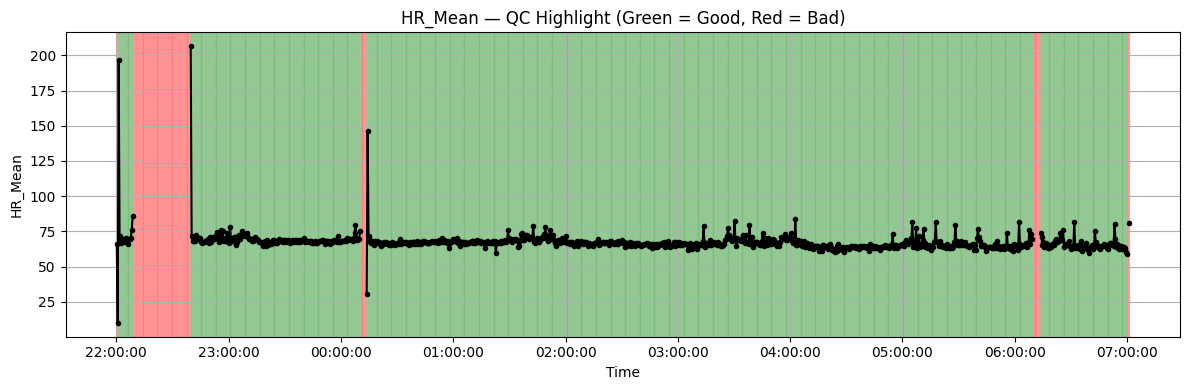

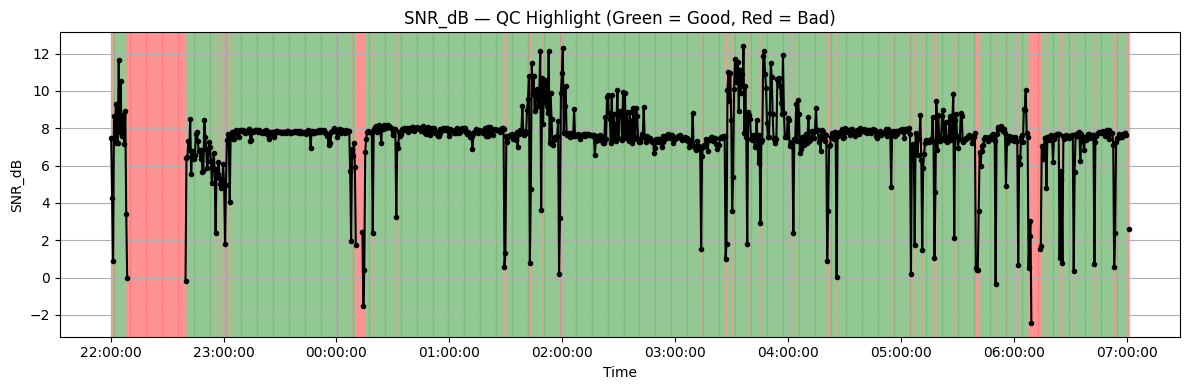

✅ Finished generating per-metric QC plots.
🫀 Plotting continuous raw ECG waveform with QC shading...
Reconstructed ECG: 6494000 samples, fs ≈ 200.00 Hz


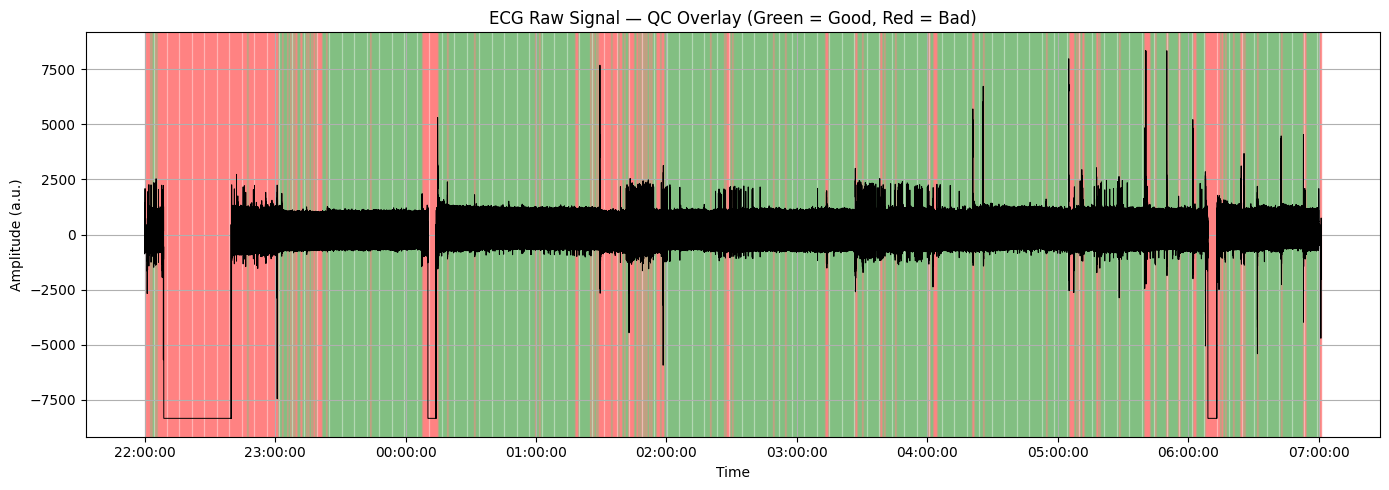

In [14]:

# ---------------- Parameters ----------------
json_path = "per_epoch_ecg.json"   # path to your saved file
time_format = "%Y-%m-%d %H:%M:%S"  # adjust if timestamps differ

# ---------------- Load JSON ----------------
with open(json_path, "r") as f:
    per_epoch = json.load(f)

df = pd.DataFrame(per_epoch)
print(f"✅ Loaded {len(df)} epochs from {json_path}")

# ---------------- Convert Times ----------------
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")
df["End_Time"] = pd.to_datetime(df["End_Time"], errors="coerce")
df["Mid_Time"] = df["Start_Time"] + (df["End_Time"] - df["Start_Time"]) / 2

# ---------------- Available Metrics ----------------
metric_flags = {
    "Clipping_Ratio": "Bad_Clip",
    "Flatline_Ratio": "Bad_Flatline",
    "Missing_Ratio": "Bad_Missing",
    "Baseline_Wander_Ratio": "Bad_Baseline",
    "HR_Mean": "Bad_HR",
    "SNR_dB": "Bad_SNR",
}

available_metrics = [m for m in metric_flags if m in df.columns]
print(f"📊 Available metrics for plotting: {available_metrics}")

# ---------------- Per-Metric Plots ----------------
for metric in available_metrics:
    bad_flag = metric_flags[metric]
    if bad_flag not in df.columns:
        continue

    # Time vs Metric value
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df["Mid_Time"], df[metric], "k.-", label=metric)

    # Shade good/bad epochs
    for _, row in df.iterrows():
        if pd.isna(row["Start_Time"]) or pd.isna(row["End_Time"]):
            continue
        color = "red" if row[bad_flag] else "green"
        ax.axvspan(row["Start_Time"], row["End_Time"], color=color, alpha=0.15)

    ax.set_title(f"{metric} — QC Highlight (Green = Good, Red = Bad)")
    ax.set_xlabel("Time")
    ax.set_ylabel(metric)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

print("✅ Finished generating per-metric QC plots.")


# ---------------- Raw ECG Waveform Reconstruction ----------------
if "Raw_Data" in df.columns:
    print("🫀 Plotting continuous raw ECG waveform with QC shading...")

    # Combine all raw samples
    raw_all = np.concatenate([
        np.array(x, dtype=float) if isinstance(x, list) else np.array([])
        for x in df["Raw_Data"]
    ])

    # Approximate sampling rate
    total_duration = (df["End_Time"].iloc[-1] - df["Start_Time"].iloc[0]).total_seconds()
    fs = len(raw_all) / total_duration if total_duration > 0 else 200

    # Generate continuous timestamp array
    t_start = df["Start_Time"].iloc[0]
    t_all = pd.date_range(start=t_start, periods=len(raw_all), freq=pd.Timedelta(seconds=1/fs))

    print(f"Reconstructed ECG: {len(raw_all)} samples, fs ≈ {fs:.2f} Hz")

    # Plot continuous ECG with shaded epochs
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(t_all, raw_all, lw=0.7, color="black")

    # Shade epochs based on QC
    for _, row in df.iterrows():
        if pd.isna(row["Start_Time"]) or pd.isna(row["End_Time"]):
            continue
        color = "red" if row["Bad_Epoch"] else "green"
        ax.axvspan(row["Start_Time"], row["End_Time"], color=color, alpha=0.18)

    ax.set_title("ECG Raw Signal — QC Overlay (Green = Good, Red = Bad)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude (a.u.)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No 'Raw_Data' field found in JSON — skipping raw signal plot.")

# FLOW Thermistor Processing and Plots

In [15]:
airflow_thermistor_df = channel_dataframes['Flow Patient (Thermistor)']

In [16]:
airflow_thermistor_df = channel_dataframes['Flow Patient (Thermistor)']
airflow_thermistor_df.head()

Relative Time (s)                 Absolute Time  Flow Patient (Thermistor)
0               0.01 2022-06-14 22:00:01.009999999                   0.001526
1               0.02 2022-06-14 22:00:01.019999999                   0.001526
2               0.03 2022-06-14 22:00:01.029999999                   0.001526
3               0.04 2022-06-14 22:00:01.039999999                   0.001526
4               0.05 2022-06-14 22:00:01.050000000                   0.001526

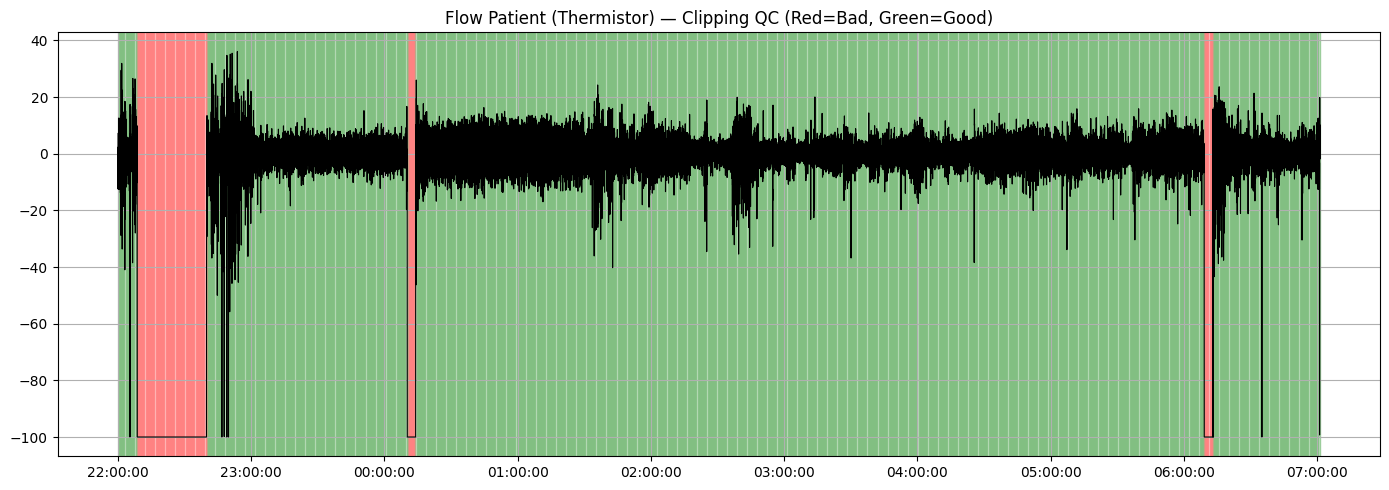

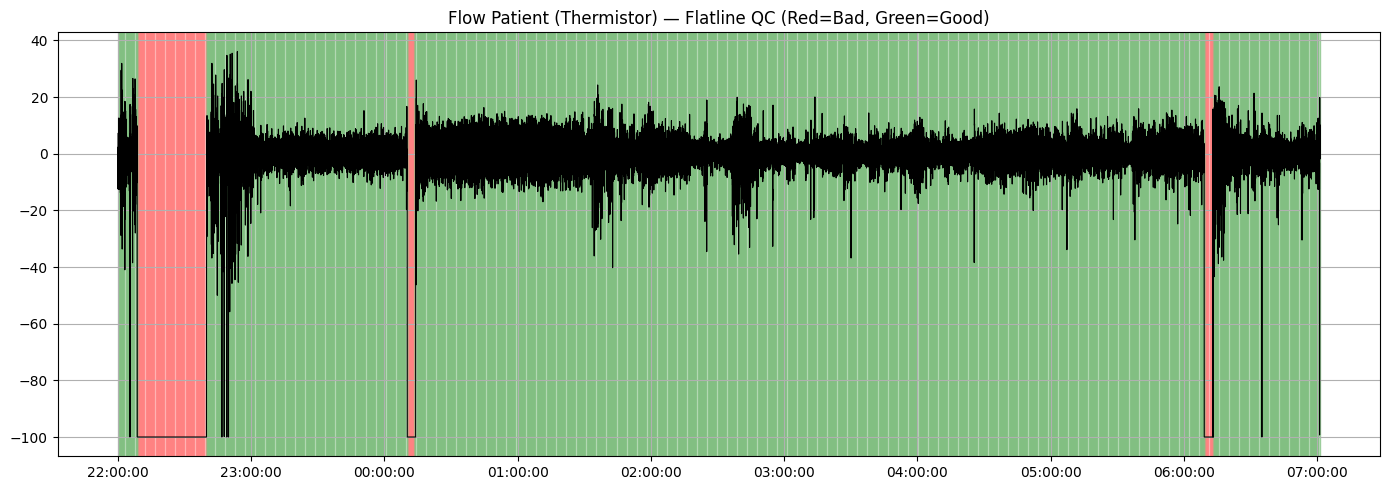

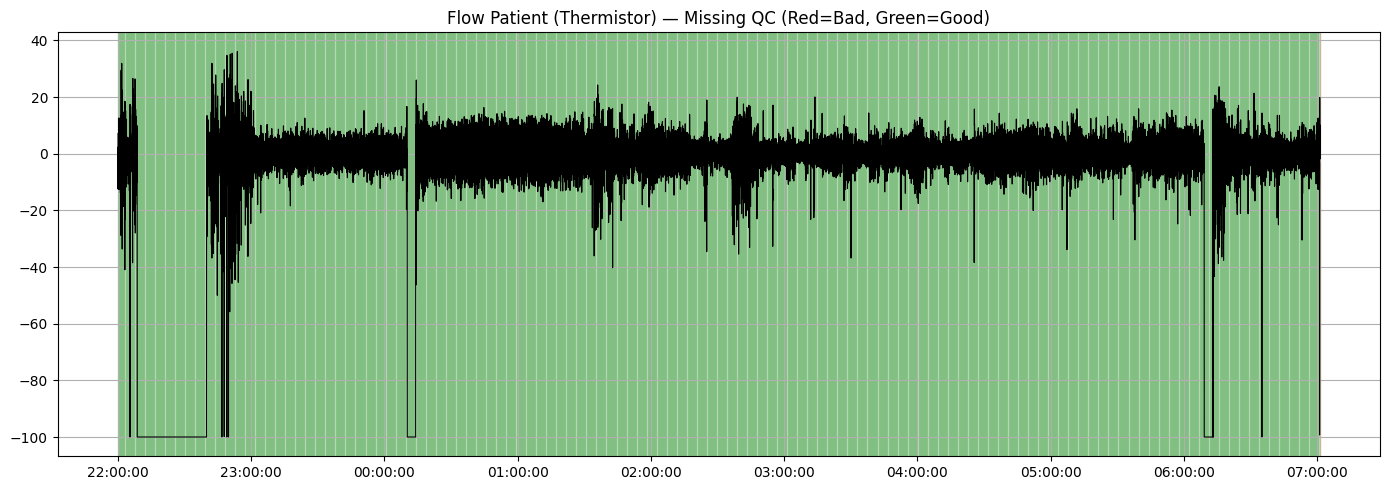

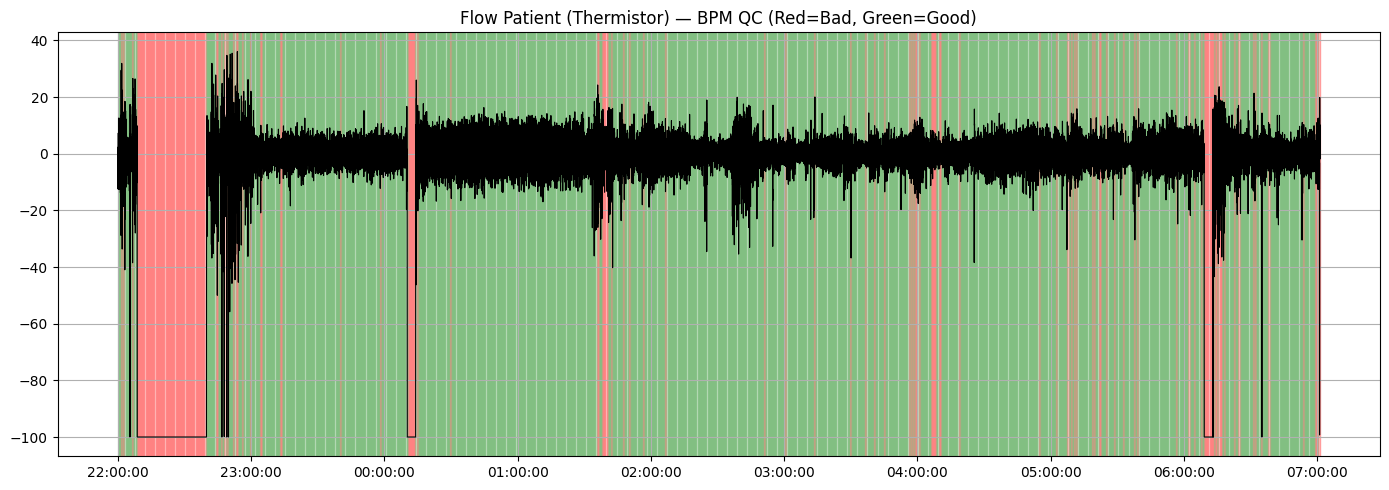

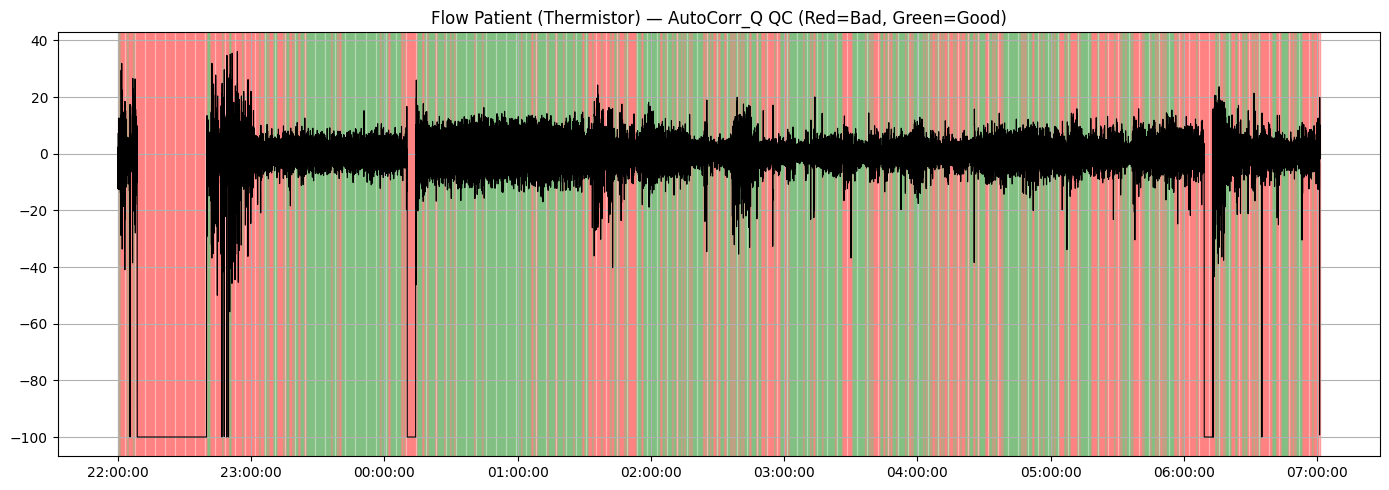

{
  "total_epochs": 1083,
  "good_epochs": 572,
  "bad_epochs": 511,
  "good_ratio": 0.528,
  "bad_ratio": 0.472
}


In [17]:
per_epoch, per_metric_json, overall_json = run_flow_qc(
    channel_name="Flow Patient (Thermistor)",
    channel_dataframes=channel_dataframes,
    fs=fs_flow_therm,
    epoch_len=30,
    json_path=False,          # or "qc_results.json" if you want to save to file
    plot="per-metric",        # options: "overall", "per-metric", "both", or 0 (none)
    clipping_max=0.50,
    flatline_max=0.50,
    missing_max=0.50,
    bpm_min=10.0,
    bpm_max=22.0,
    auto_min=0.5              # ✅ autocorrelation threshold (0–1 scale)
)

# Print overall QC summary
print(json.dumps(overall_json, indent=2))

In [18]:
# --- Save per_epoch to a separate JSON file ---
with open("per_epoch_flow_temp.json", "w") as f:
    json.dump(per_epoch, f, indent=2)

print("✅ Saved per-epoch QC details to per_epoch.json")

✅ Saved per-epoch QC details to per_epoch.json


✅ Loaded 1083 epochs from per_epoch_flow_temp.json
📊 Available metrics for plotting: ['Clipping_Ratio', 'Flatline_Ratio', 'Missing_Ratio', 'BPM']


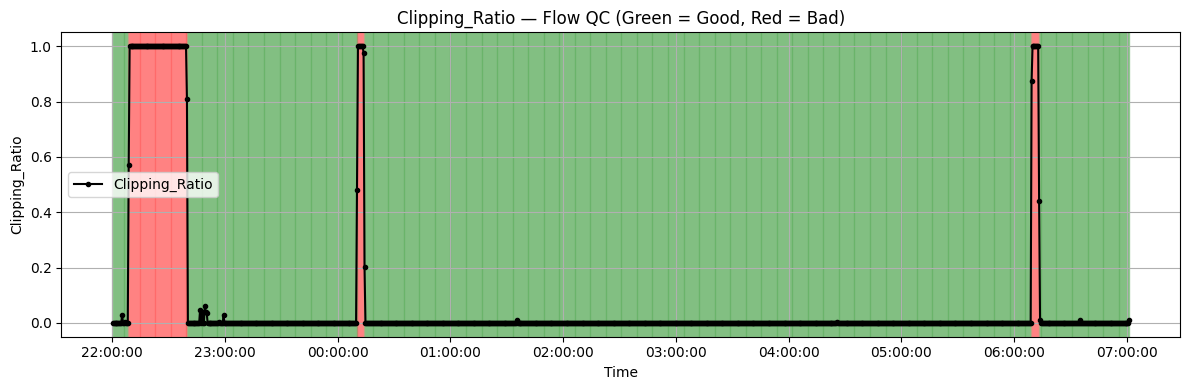

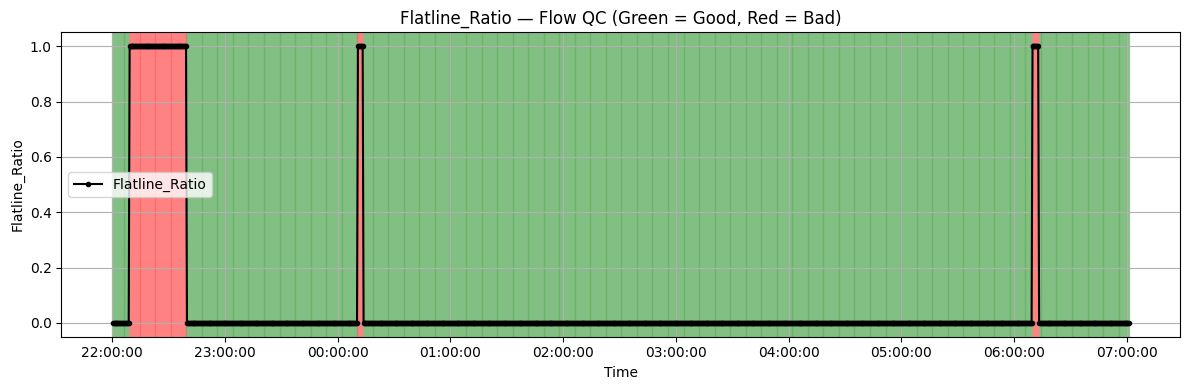

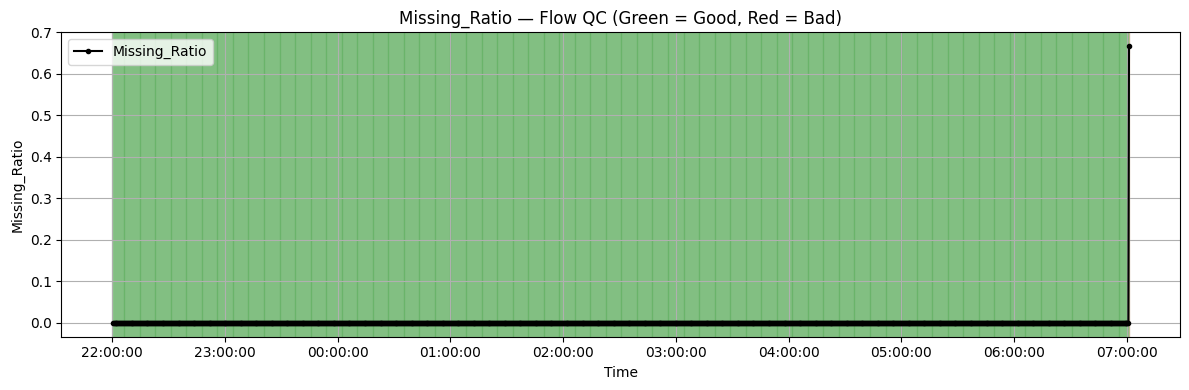

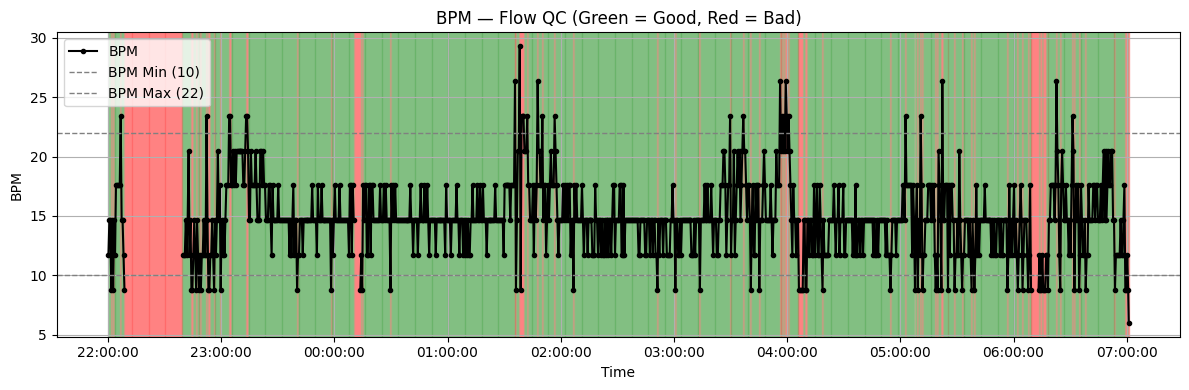

📈 Plotting dedicated Autocorrelation Quality (AutoCorr_Q)...


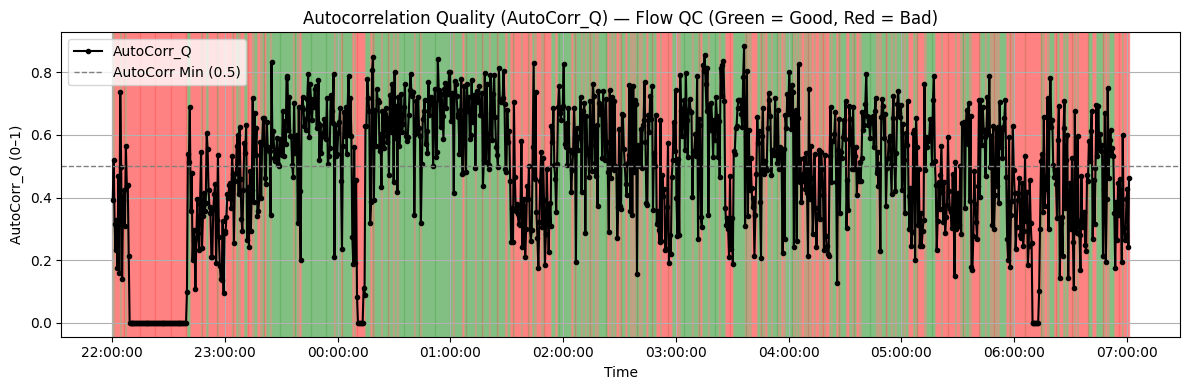

✅ Finished generating QC plots (AutoCorr_Q shown once).
🫀 Plotting raw waveform with QC shading...
Reconstructed raw signal: 3247000 samples, fs ≈ 100.00 Hz


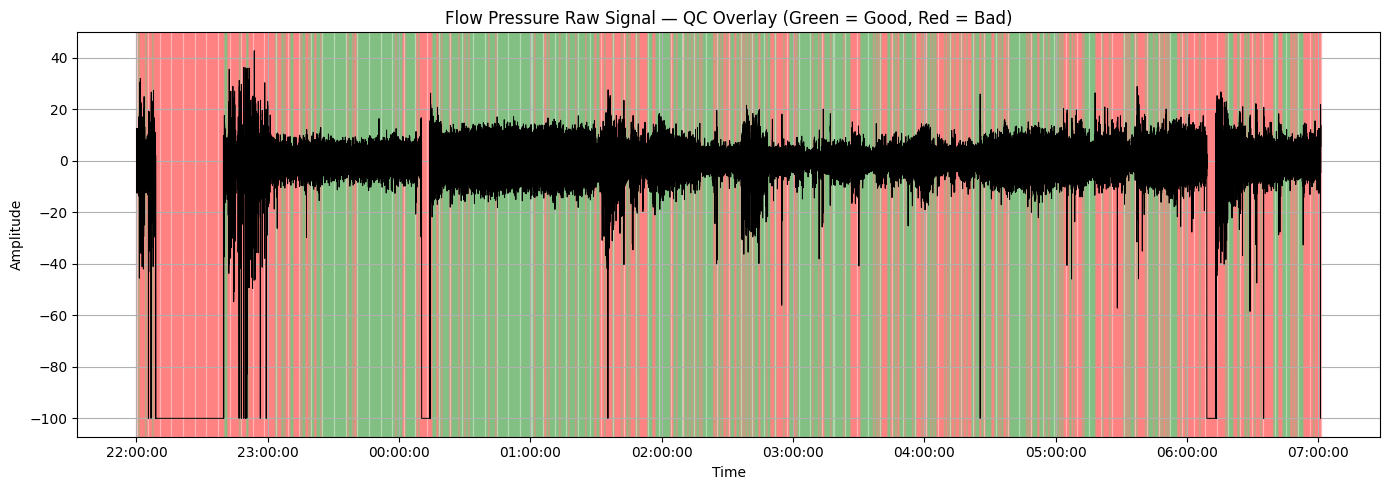

In [19]:
# ---- Load the saved QC file ----
json_path = "per_epoch_flow_temp.json"

with open(json_path, "r") as f:
    per_epoch = json.load(f)

df = pd.DataFrame(per_epoch)
print(f"✅ Loaded {len(df)} epochs from {json_path}")

# ---- Convert times ----
df["Start_Time_ISO"] = pd.to_datetime(df["Start_Time_ISO"], errors="coerce")
df["End_Time_ISO"] = pd.to_datetime(df["End_Time_ISO"], errors="coerce")
df["Mid_Time"] = df["Start_Time_ISO"] + (df["End_Time_ISO"] - df["Start_Time_ISO"]) / 2

# ---- Define metrics and flags (AutoCorr_Q excluded from loop) ----
metric_flags = {
    "Clipping_Ratio": "Bad_Clip",
    "Flatline_Ratio": "Bad_Flatline",
    "Missing_Ratio": "Bad_Missing",
    "BPM": "Bad_BPM",
}

available_metrics = [m for m in metric_flags if m in df.columns]
print(f"📊 Available metrics for plotting: {available_metrics}")

# ---- Helper for shading ----
def shade_epochs(ax, start_col, end_col, flag_col):
    """Shade epochs red (bad) or green (good)."""
    for _, row in df.iterrows():
        if pd.isna(row[start_col]) or pd.isna(row[end_col]):
            continue
        color = "red" if row[flag_col] else "green"
        ax.axvspan(row[start_col], row[end_col], color=color, alpha=0.18)

# ---- Plot each QC metric ----
for metric in available_metrics:
    flag = metric_flags[metric]
    if flag not in df.columns:
        continue

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df["Mid_Time"], df[metric], "k.-", label=metric)

    # --- Add threshold lines ---
    if metric == "BPM":
        ax.axhline(10.0, color="gray", linestyle="--", lw=1, label="BPM Min (10)")
        ax.axhline(22.0, color="gray", linestyle="--", lw=1, label="BPM Max (22)")

    # --- Shading ---
    shade_epochs(ax, "Start_Time_ISO", "End_Time_ISO", flag)

    ax.set_title(f"{metric} — Flow QC (Green = Good, Red = Bad)")
    ax.set_xlabel("Time")
    ax.set_ylabel(metric)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# ---- Dedicated Autocorrelation Quality Plot ----
if "AutoCorr_Q" in df.columns:
    print("📈 Plotting dedicated Autocorrelation Quality (AutoCorr_Q)...")

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df["Mid_Time"], df["AutoCorr_Q"], "k.-", label="AutoCorr_Q")

    # Add autocorrelation threshold line
    ax.axhline(0.5, color="gray", linestyle="--", lw=1, label="AutoCorr Min (0.5)")

    shade_epochs(ax, "Start_Time_ISO", "End_Time_ISO", "Bad_AutoCorr")
    ax.set_title("Autocorrelation Quality (AutoCorr_Q) — Flow QC (Green = Good, Red = Bad)")
    ax.set_xlabel("Time")
    ax.set_ylabel("AutoCorr_Q (0–1)")
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

print("✅ Finished generating QC plots (AutoCorr_Q shown once).")

# ---- Combine all raw segments into one continuous trace ----
if "Raw_Data" in df.columns:
    print("🫀 Plotting raw waveform with QC shading...")

    # Concatenate all segments
    raw_all = np.concatenate([
        np.array(x, dtype=float) if isinstance(x, list) else np.array([])
        for x in df["Raw_Data"]
    ])

    # Approximate sampling rate and create time base
    total_duration = (df["End_Time_ISO"].iloc[-1] - df["Start_Time_ISO"].iloc[0]).total_seconds()
    fs = len(raw_all) / total_duration if total_duration > 0 else 100
    t_start = df["Start_Time_ISO"].iloc[0]
    t_all = pd.date_range(start=t_start, periods=len(raw_all), freq=pd.Timedelta(seconds=1/fs))

    print(f"Reconstructed raw signal: {len(raw_all)} samples, fs ≈ {fs:.2f} Hz")

    # ---- Plot raw waveform with shaded QC epochs ----
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(t_all, raw_all, lw=0.7, color="black")
    shade_epochs(ax, "Start_Time_ISO", "End_Time_ISO", "Bad_Epoch")
    ax.set_title("Flow Pressure Raw Signal — QC Overlay (Green = Good, Red = Bad)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No 'Raw_Data' field found in JSON — skipping raw signal plot.")

# FLOW Pressure Processing and Plots

In [20]:
airflow_pressure_df = channel_dataframes['Flow Patient (Pressure)']

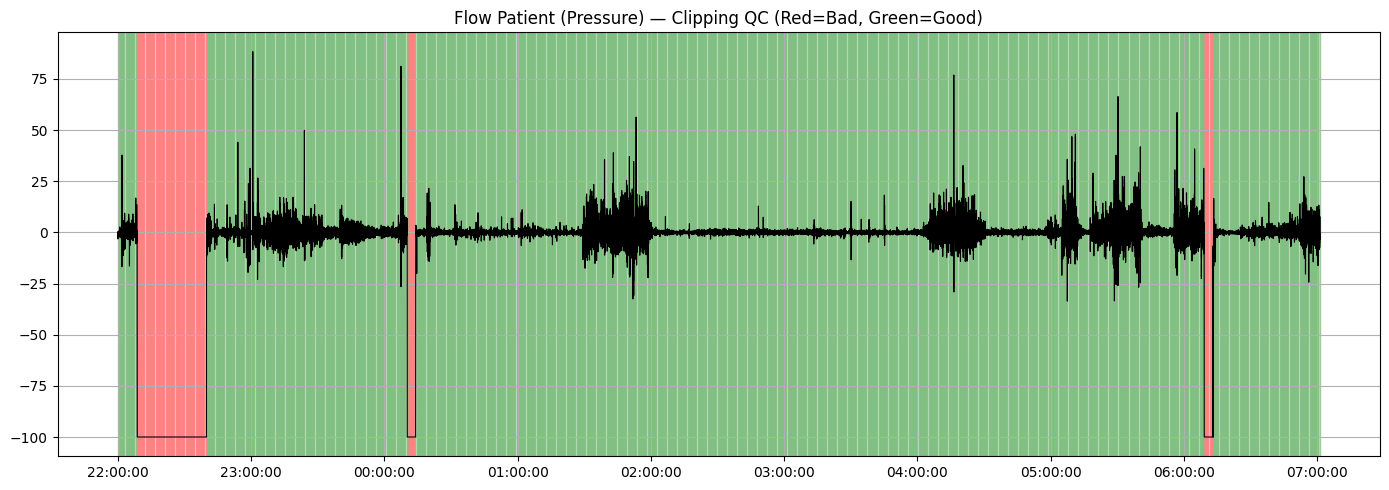

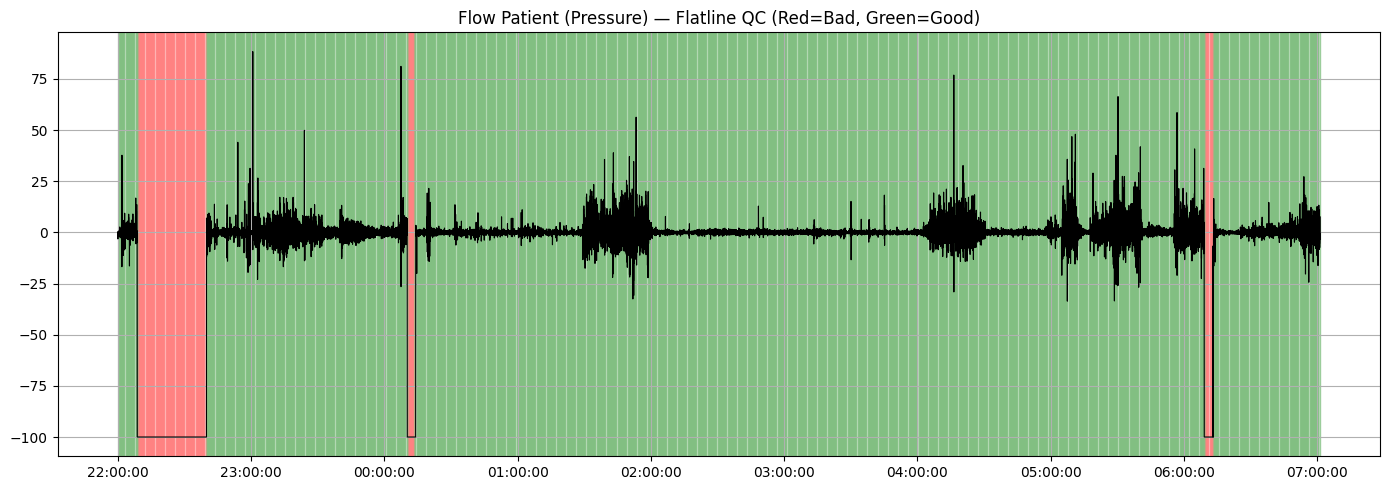

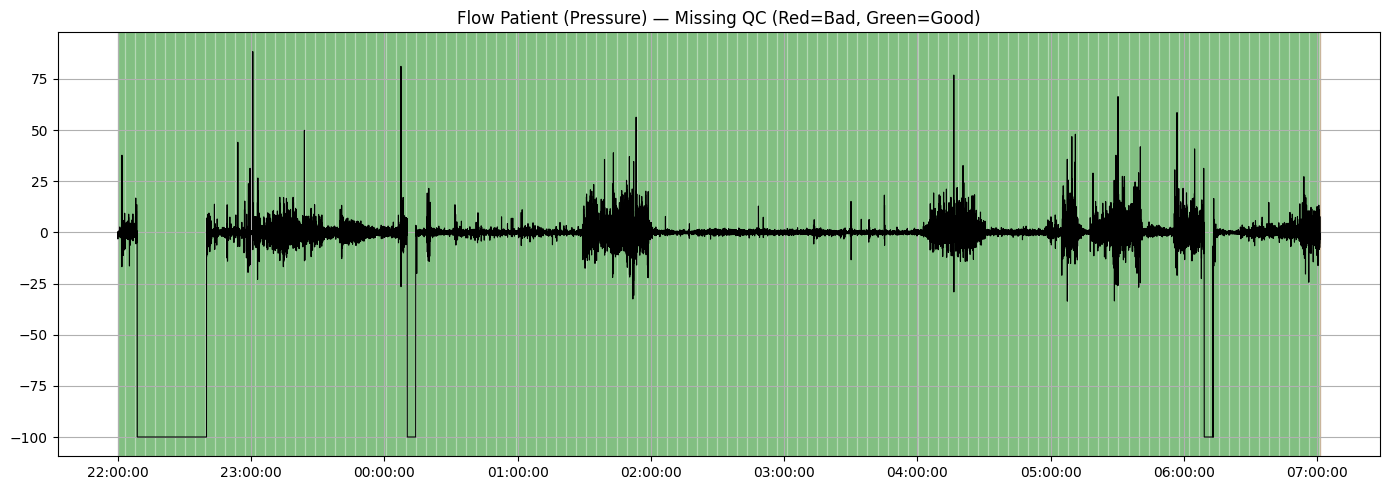

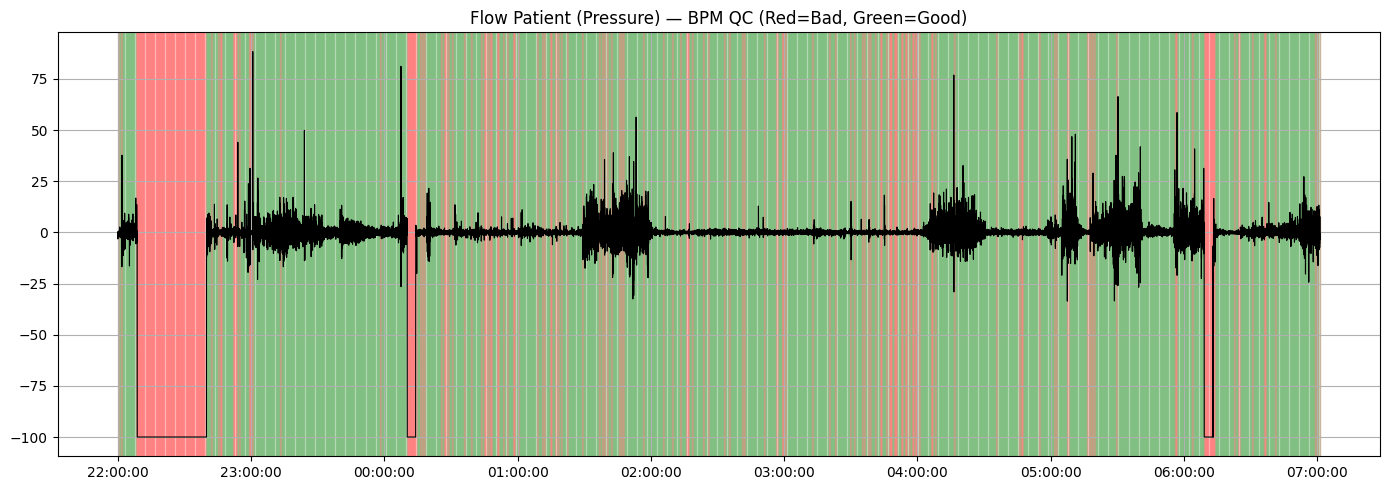

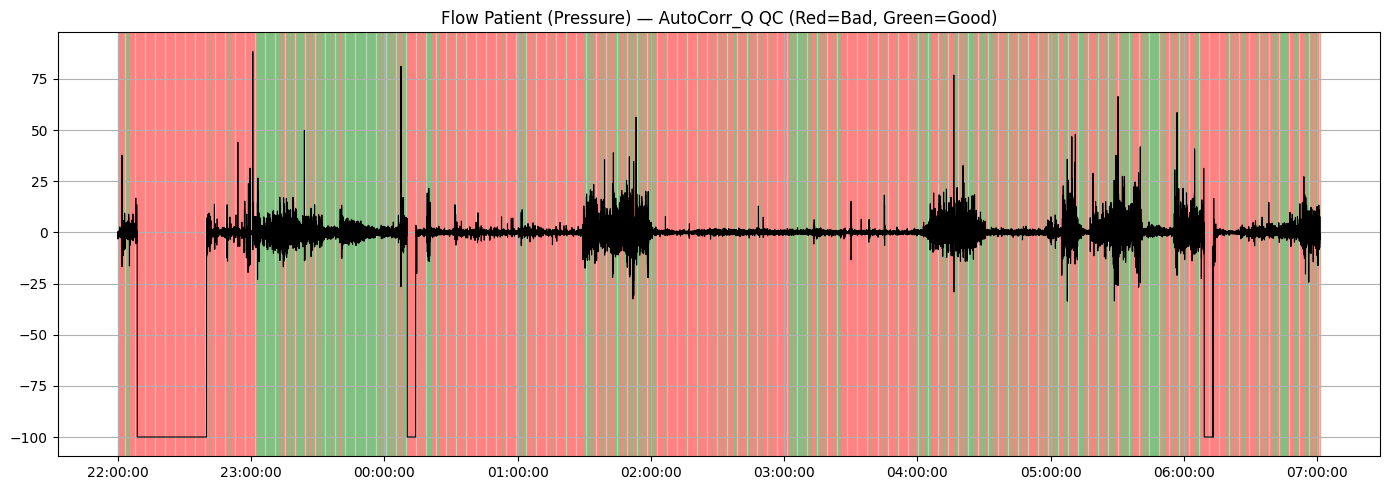

{
  "total_epochs": 1083,
  "good_epochs": 374,
  "bad_epochs": 709,
  "good_ratio": 0.345,
  "bad_ratio": 0.655
}


In [21]:
per_epoch, per_metric_json, overall_json = run_flow_qc(
    channel_name="Flow Patient (Pressure)",
    channel_dataframes=channel_dataframes,
    fs=fs_flow_press,
    epoch_len=30,
    json_path=False,          # or "qc_results.json" if you want to save to file
    plot="per-metric",        # options: "overall", "per-metric", "both", or 0 (none)
    clipping_max=0.50,
    flatline_max=0.50,
    missing_max=0.50,
    bpm_min=10.0,
    bpm_max=22.0,
    auto_min=0.5              # ✅ autocorrelation threshold (0–1 scale)
)

# Print overall QC summary
print(json.dumps(overall_json, indent=2))

In [22]:
# --- Save per_epoch to a separate JSON file ---
with open("per_epoch_flow_pressure.json", "w") as f:
    json.dump(per_epoch, f, indent=2)

print("✅ Saved per-epoch QC details to per_epoch.json")

✅ Saved per-epoch QC details to per_epoch.json


✅ Loaded 1083 epochs from per_epoch_flow_pressure.json
📊 Available metrics for plotting: ['Clipping_Ratio', 'Flatline_Ratio', 'Missing_Ratio', 'BPM']


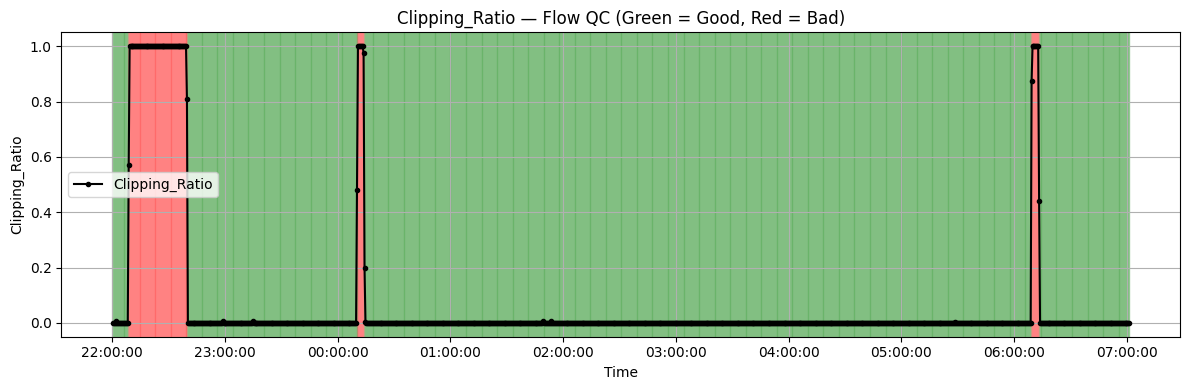

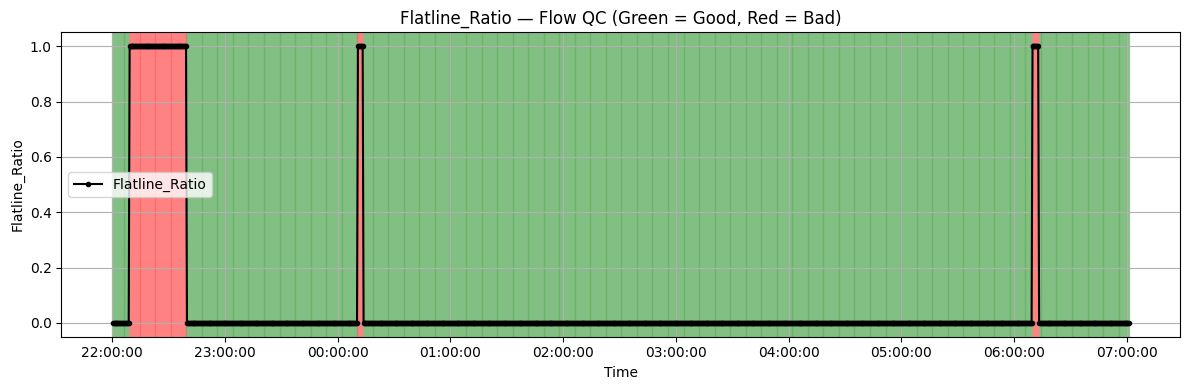

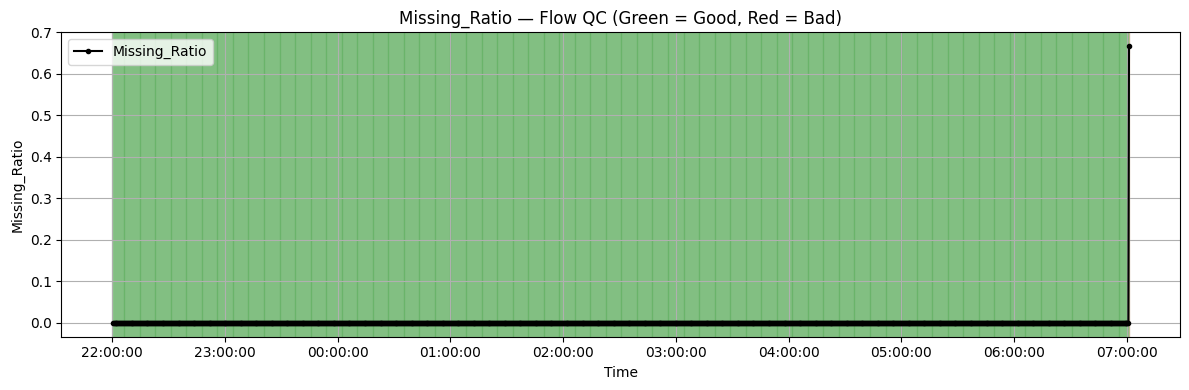

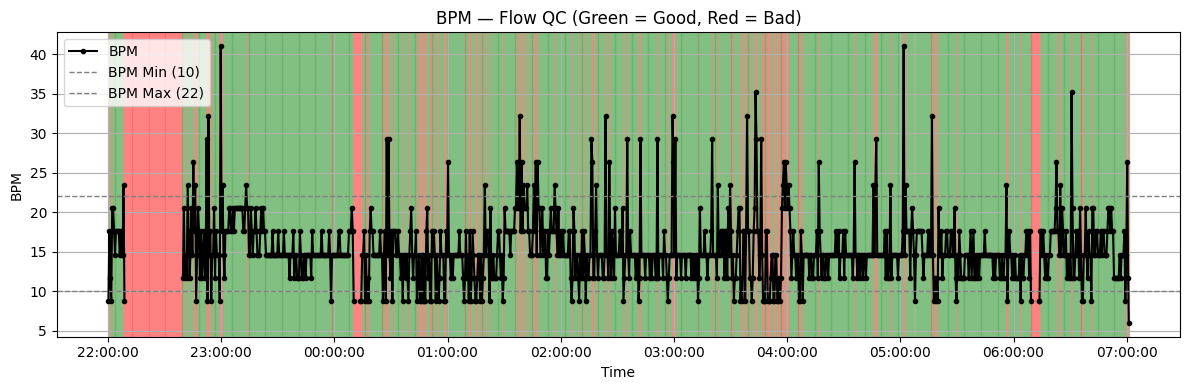

📈 Plotting dedicated Autocorrelation Quality (AutoCorr_Q)...


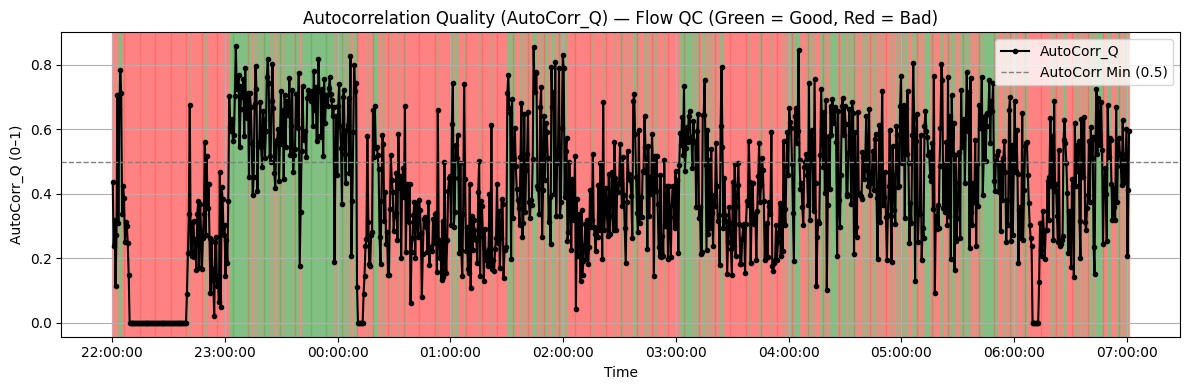

✅ Finished generating QC plots (AutoCorr_Q shown once).
🫀 Plotting raw waveform with QC shading...
Reconstructed raw signal: 3247000 samples, fs ≈ 100.00 Hz


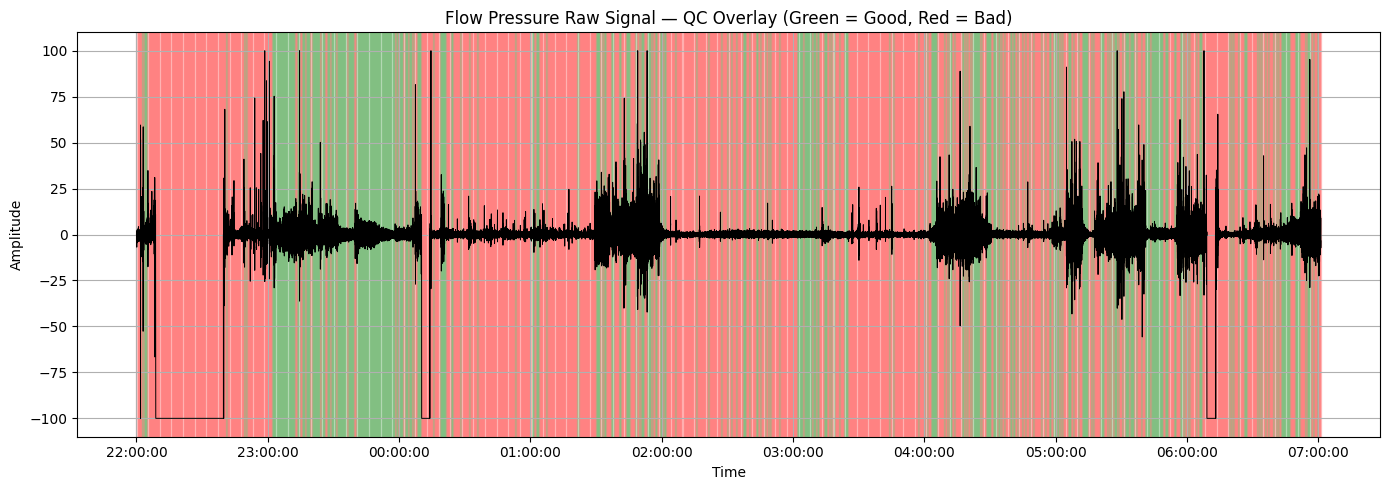

In [23]:
# ---- Load the saved QC file ----
json_path = "per_epoch_flow_pressure.json"

with open(json_path, "r") as f:
    per_epoch = json.load(f)

df = pd.DataFrame(per_epoch)
print(f"✅ Loaded {len(df)} epochs from {json_path}")

# ---- Convert times ----
df["Start_Time_ISO"] = pd.to_datetime(df["Start_Time_ISO"], errors="coerce")
df["End_Time_ISO"] = pd.to_datetime(df["End_Time_ISO"], errors="coerce")
df["Mid_Time"] = df["Start_Time_ISO"] + (df["End_Time_ISO"] - df["Start_Time_ISO"]) / 2

# ---- Define metrics and flags (AutoCorr_Q excluded from loop) ----
metric_flags = {
    "Clipping_Ratio": "Bad_Clip",
    "Flatline_Ratio": "Bad_Flatline",
    "Missing_Ratio": "Bad_Missing",
    "BPM": "Bad_BPM",
}

available_metrics = [m for m in metric_flags if m in df.columns]
print(f"📊 Available metrics for plotting: {available_metrics}")

# ---- Helper for shading ----
def shade_epochs(ax, start_col, end_col, flag_col):
    """Shade epochs red (bad) or green (good)."""
    for _, row in df.iterrows():
        if pd.isna(row[start_col]) or pd.isna(row[end_col]):
            continue
        color = "red" if row[flag_col] else "green"
        ax.axvspan(row[start_col], row[end_col], color=color, alpha=0.18)

# ---- Plot each QC metric ----
for metric in available_metrics:
    flag = metric_flags[metric]
    if flag not in df.columns:
        continue

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df["Mid_Time"], df[metric], "k.-", label=metric)

    # --- Add threshold lines ---
    if metric == "BPM":
        ax.axhline(10.0, color="gray", linestyle="--", lw=1, label="BPM Min (10)")
        ax.axhline(22.0, color="gray", linestyle="--", lw=1, label="BPM Max (22)")

    # --- Shading ---
    shade_epochs(ax, "Start_Time_ISO", "End_Time_ISO", flag)

    ax.set_title(f"{metric} — Flow QC (Green = Good, Red = Bad)")
    ax.set_xlabel("Time")
    ax.set_ylabel(metric)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# ---- Dedicated Autocorrelation Quality Plot ----
if "AutoCorr_Q" in df.columns:
    print("📈 Plotting dedicated Autocorrelation Quality (AutoCorr_Q)...")

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df["Mid_Time"], df["AutoCorr_Q"], "k.-", label="AutoCorr_Q")

    # Add autocorrelation threshold line
    ax.axhline(0.5, color="gray", linestyle="--", lw=1, label="AutoCorr Min (0.5)")

    shade_epochs(ax, "Start_Time_ISO", "End_Time_ISO", "Bad_AutoCorr")
    ax.set_title("Autocorrelation Quality (AutoCorr_Q) — Flow QC (Green = Good, Red = Bad)")
    ax.set_xlabel("Time")
    ax.set_ylabel("AutoCorr_Q (0–1)")
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

print("✅ Finished generating QC plots (AutoCorr_Q shown once).")

# ---- Combine all raw segments into one continuous trace ----
if "Raw_Data" in df.columns:
    print("🫀 Plotting raw waveform with QC shading...")

    # Concatenate all segments
    raw_all = np.concatenate([
        np.array(x, dtype=float) if isinstance(x, list) else np.array([])
        for x in df["Raw_Data"]
    ])

    # Approximate sampling rate and create time base
    total_duration = (df["End_Time_ISO"].iloc[-1] - df["Start_Time_ISO"].iloc[0]).total_seconds()
    fs = len(raw_all) / total_duration if total_duration > 0 else 100
    t_start = df["Start_Time_ISO"].iloc[0]
    t_all = pd.date_range(start=t_start, periods=len(raw_all), freq=pd.Timedelta(seconds=1/fs))

    print(f"Reconstructed raw signal: {len(raw_all)} samples, fs ≈ {fs:.2f} Hz")

    # ---- Plot raw waveform with shaded QC epochs ----
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(t_all, raw_all, lw=0.7, color="black")
    shade_epochs(ax, "Start_Time_ISO", "End_Time_ISO", "Bad_Epoch")
    ax.set_title("Flow Pressure Raw Signal — QC Overlay (Green = Good, Red = Bad)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No 'Raw_Data' field found in JSON — skipping raw signal plot.")
